In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd "/content/drive/MyDrive/cs7643-deep-learning/project"

/content/drive/MyDrive/cs7643-deep-learning/project


In [3]:
!nvidia-smi -L

GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-369c7b5b-b501-44b1-3924-645672c27bbe)


In [4]:
!pip install -q -U watermark

In [5]:
!pip install -qq transformers

     |████████████████████████████████| 2.1MB 12.5MB/s 
     |████████████████████████████████| 3.3MB 55.6MB/s 
     |████████████████████████████████| 901kB 40.1MB/s 


In [6]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import gc
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 77
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [7]:
data = pd.read_csv("yelp_humor_merged_v1.csv")
data

,business_id,user_id,categories,review,review_bus_name,word_count,funny,humor
0,w-PDAtfzTJgBYVNtn8AsjQ,fyKNlOFv3FiZnVw_1Eym_g,"Asian Fusion, Restaurants, Thai, Vietnamese, C...",This place is down the street from my work. I ...,Food Shui. This place is down the street from ...,75,0,0
1,U1TNktr9XCBjRlEXqKxUnQ,mz09cepMFCaFgX8hzSPcKQ,"American (Traditional), American (New), Restau...",I really want to like Hop's Chicken but each t...,Hop's Chicken. I really want to like Hop's Chi...,64,0,0
2,WIv0U9nwIVYuY9lVbcsC5A,hsOX9uabJ6IJhlCP5fTsQA,"Fashion, Shopping, Used, Vintage & Consignment...",Disappointed to not to find vintage clothes. G...,Crossroads Trading Company. Disappointed to no...,52,0,0
3,I6R2gKkK8Rzymja9GfI19A,RrjStOB9-PqWLBvDIUOSyQ,"Breakfast & Brunch, Cocktail Bars, Restaurants...",Loved the roasted chicken here. Everything abo...,Aquitaine. Loved the roasted chicken here. Eve...,28,0,0
4,e1JiReDnTaqcHWTOcnkunQ,ZMTyAmYAk0UvMdzy-JrA3g,"Mexican, Breakfast & Brunch, Tacos, Bars, Soup...",Where to begin.... the menu was confusing beca...,Fuzzy's Taco Shop. Where to begin.... the menu...,173,0,0
...,...,...,...,...,...,...,...,...
840859,wvFZ06nmPmQ2-IVoPqVYLA,c56oZZbK3bt8vFA8lz4wfQ,"Arts & Entertainment, Paint & Sip, Art Classes...",So much fun! I picked this location based on t...,Painting with a Twist. So much fun! I picked t...,86,3,1
840860,ngmLL5Y5OT-bYHKU0kKrYA,3QpBYKpzMHFmyUjBn2nXjA,"Restaurants, Middle Eastern, Mediterranean, Pe...",I would recommend you to read this review if y...,Zora Grille. I would recommend you to read thi...,168,3,1
840861,ngmLL5Y5OT-bYHKU0kKrYA,XnlQAgKJUAQZMCxGIX9P5Q,"Restaurants, Middle Eastern, Mediterranean, Pe...",I visited on a weekday lunch with several cowo...,Zora Grille. I visited on a weekday lunch with...,127,3,1
840862,ngmLL5Y5OT-bYHKU0kKrYA,nJZ7f4AfZKyDKdIZ362mIw,"Restaurants, Middle Eastern, Mediterranean, Pe...","As in a couple of other cases, Zora Grille's r...","Zora Grille. As in a couple of other cases, Zo...",735,9,1


In [8]:
word_cnt_threshold=400
humor_threshold=10

In [9]:
df = data[(data['word_count'] <= word_cnt_threshold) & ((data['funny']>=humor_threshold) | (data['funny'] == 0))]
df

,business_id,user_id,categories,review,review_bus_name,word_count,funny,humor
0,w-PDAtfzTJgBYVNtn8AsjQ,fyKNlOFv3FiZnVw_1Eym_g,"Asian Fusion, Restaurants, Thai, Vietnamese, C...",This place is down the street from my work. I ...,Food Shui. This place is down the street from ...,75,0,0
1,U1TNktr9XCBjRlEXqKxUnQ,mz09cepMFCaFgX8hzSPcKQ,"American (Traditional), American (New), Restau...",I really want to like Hop's Chicken but each t...,Hop's Chicken. I really want to like Hop's Chi...,64,0,0
2,WIv0U9nwIVYuY9lVbcsC5A,hsOX9uabJ6IJhlCP5fTsQA,"Fashion, Shopping, Used, Vintage & Consignment...",Disappointed to not to find vintage clothes. G...,Crossroads Trading Company. Disappointed to no...,52,0,0
3,I6R2gKkK8Rzymja9GfI19A,RrjStOB9-PqWLBvDIUOSyQ,"Breakfast & Brunch, Cocktail Bars, Restaurants...",Loved the roasted chicken here. Everything abo...,Aquitaine. Loved the roasted chicken here. Eve...,28,0,0
4,e1JiReDnTaqcHWTOcnkunQ,ZMTyAmYAk0UvMdzy-JrA3g,"Mexican, Breakfast & Brunch, Tacos, Bars, Soup...",Where to begin.... the menu was confusing beca...,Fuzzy's Taco Shop. Where to begin.... the menu...,173,0,0
...,...,...,...,...,...,...,...,...
840811,yQL8SrSETbbCI1U5esVJQw,Ls2StWJi63YkwCN00A_17w,"Restaurants, Pizza, Italian",So I have nothing at all whatsoever to change ...,Ciao! Pizza & Pasta. So I have nothing at all ...,27,16,1
840816,r5Uag1JqYjr2nbxQCVqm8A,a6ywt-6Ee1iAt2SbWXW1rA,"Restaurants, Noodles, Salad, Vietnamese, Veget...",This place is great for lunch - the $8.95 lunc...,Saigon Noodle & Grill. This place is great for...,55,10,1
840832,r5Uag1JqYjr2nbxQCVqm8A,eYd1sygl0Thd2JRQTVgX5A,"Restaurants, Noodles, Salad, Vietnamese, Veget...",Best pho in Orlando and I ought to know. I liv...,Saigon Noodle & Grill. Best pho in Orlando and...,136,18,1
840853,uXdQkuEtvLAzfc3MsO-sTQ,K8VSrOOCdXS9VX5S66W4GQ,"Restaurants, Mexican, Latin American","I went to Mama's Cocina Latina, because it's s...",Mama's Cocina Latina. I went to Mama's Cocina ...,257,22,1


In [10]:
df['humor'].value_counts()

0    491985
1     35901
Name: humor, dtype: int64

In [11]:
df['funny'].value_counts()

0      491985
10       6128
11       4702
12       3655
13       2954
        ...  
158         1
161         1
162         1
166         1
392         1
Name: funny, Length: 161, dtype: int64

In [12]:
df['funny'].value_counts()[:20]

0     491985
10      6128
11      4702
12      3655
13      2954
14      2442
15      2008
16      1732
17      1398
18      1265
19       970
20       929
21       772
22       643
23       616
24       533
25       458
26       430
27       319
28       302
Name: funny, dtype: int64

In [13]:
max(df['word_count'].unique())

400

In [14]:
humor_sample = min(36000, df['humor'].value_counts()[1])
humor_sample

35901

In [15]:

not_humor_split = 0.5
not_humor_sample = int(humor_sample * (not_humor_split) / (1 - not_humor_split))
not_humor_sample

35901

In [16]:
df_humor = df[df['humor']==1]
df_humor = df_humor.sample(n=humor_sample, random_state=RANDOM_SEED)
df_humor

,business_id,user_id,categories,review,review_bus_name,word_count,funny,humor
675866,oObgKV1J0u85YC6Xw8_QcQ,ZH-OEKC-dOGQszEnXLpXnw,"Shopping, Discount Store",Ocean State Job Lot is a strange world where y...,Ocean State Job Lot. Ocean State Job Lot is a ...,265,26,1
758914,tkkN7PqXNKoFdBMoLuD5gw,AkBZo05E0KApriZqxXgfRQ,"Professional Services, Local Services, Shippin...","It is a riddle, wrapped in a mystery, inside a...",FedEx Office Print & Ship Center. It is a ridd...,237,11,1
577602,U8M3vPFH0O82-T9r35GiIQ,s1n24mcOD6fUIvfin1mrBQ,"Arts & Entertainment, Music Venues, Nightlife,...",I swear these are the most obnoxious people to...,The Black Heart. I swear these are the most ob...,74,11,1
735698,mbNRIX5ROAzeDAmCVM_xzg,hizGc5W1tBHPghM5YKCAtg,"Restaurants, Pizza",The amount of pizza I've eaten since moving to...,Via 313 Pizza - East Side. The amount of pizza...,112,18,1
593842,tBYvSXdYG9DxJczMN-ep4A,jhuCv6dzRQ6a_kEaDvcrTA,"Food, Beer, Wine & Spirits, Coffee & Tea, Deli...",I shop at World Foods at least once every thre...,World Foods. I shop at World Foods at least on...,294,14,1
...,...,...,...,...,...,...,...,...
812262,bJ-RRBKUmuPULU3BdbR55A,NaSI8Xl97MnVZ627i-D_Kg,"Caterers, Restaurants, Fast Food, Event Planni...","Listen to me carefully, shhhhhh, listen..... (...",Food Wall Chinese Restaurant. Listen to me car...,119,10,1
742129,sQnW1dh_VXSIBOWYN59zTg,chhv5egoLSXHs4my1HCJeg,"Event Planning & Services, Resorts, Hotels, Ho...",We had such a great time staying at this resor...,Disney's Port Orleans Resort - French Quarter....,260,11,1
574054,WiKvK8vtlSvu2EowbE-BOg,0wBI9RiVyf9HnL1IuGCCUw,"Wine Bars, Bars, Salad, Soup, Nightlife, Itali...",I'll keep it short and sweet. Had a gift card ...,Olive Garden Italian Restaurant. I'll keep it ...,62,15,1
675934,hY6RjYHE4MKLFl2bYNW9YQ,Hi10sGSZNxQH3NLyWSZ1oA,"Restaurants, Chinese","I like to Tsingtao people, in fact it's my job...","Tsingtao Brother. I like to Tsingtao people, i...",301,27,1


In [17]:
df_not_humor = df[df['humor']==0]
df_not_humor = df_not_humor.sample(n=not_humor_sample, random_state=RANDOM_SEED)
df_not_humor

,business_id,user_id,categories,review,review_bus_name,word_count,funny,humor
392098,WQSziTOUaS36KC1esA1Xaw,in3r5GFw1UscA2T14Ttv7A,"American (New), Steakhouses, Restaurants",Came here on my one year anniversary over 20 y...,J Alexander's. Came here on my one year annive...,26,0,0
438504,TXldmFTBlj0_Ov3dm3eE0g,vB5wh5CSFZeXM40U9fmWvg,"Desserts, Coffee & Tea, Grocery, Food, Restaur...",Probably one of the healthiest places you can ...,Rolling In Thyme & Dough. Probably one of the ...,112,0,0
75062,TKEmPN45epfqtNQq6wY8Dg,Htj76IxLhEo27rvgeudm5Q,"American (Traditional), Steakhouses, Restauran...",ALC- you're such a tease! I no longer live in ...,ALC Steaks. ALC- you're such a tease! I no lon...,237,0,0
487689,-8LdHGN1xVpmvfy0efwzqg,-RkK5vSsSnZiERZZYwZAfw,"Sandwiches, Cafes, Food, Coffee & Tea, Bakerie...",Love the atmosphere and decor of this place. P...,La Forêt. Love the atmosphere and decor of thi...,35,0,0
326347,Wv4PC5QIg38mgP3xR505uw,kGtK19gpDV_lZJfLxjVJaA,"Jewelry, Watches, Local Services, Jewelry Repa...",Not even a one star.... Crooks. Brought a watc...,Boston Watch Clock & Jewelry Repair. Not even ...,73,0,0
...,...,...,...,...,...,...,...,...
418304,Trfgxo0lVgtAgVnvfjZrUw,xn34jsqp3V-2jhiWg8GVow,"Window Washing, Real Estate, Carpet Cleaning, ...",I have used Ground to Crown twice for overall ...,Ground To Crown. I have used Ground to Crown t...,44,0,0
2698,OFEnwG1VDgfa_bgOKPOn3A,vT7AuaOE941F36WI8ZkhEA,"Japanese, Restaurants, Sushi Bars",A friend took me here. The place was nice and ...,Shoya Izakaya. A friend took me here. The plac...,70,0,0
432262,P7xWC-tsKwPsFQ4zFsZxYw,EnDe-2S9DMaAoyRk4EtwWg,"Tours, Amusement Parks, Restaurants, Active Li...",I love this park! The Harry Potter part of thi...,Universal's Islands of Adventure. I love this ...,42,0,0
182554,mp3OF0yBX-r_6YZnX-fJgw,PU1o1xwRiUbrd78MNe29jQ,"Coffee & Tea, Tea Rooms, Food, Vietnamese, Res...",This place is consistently the #1 Vietnamese r...,Heart Stock Noodle & Tea. This place is consis...,54,0,0


In [18]:
df = pd.concat([df_humor, df_not_humor])
df

,business_id,user_id,categories,review,review_bus_name,word_count,funny,humor
675866,oObgKV1J0u85YC6Xw8_QcQ,ZH-OEKC-dOGQszEnXLpXnw,"Shopping, Discount Store",Ocean State Job Lot is a strange world where y...,Ocean State Job Lot. Ocean State Job Lot is a ...,265,26,1
758914,tkkN7PqXNKoFdBMoLuD5gw,AkBZo05E0KApriZqxXgfRQ,"Professional Services, Local Services, Shippin...","It is a riddle, wrapped in a mystery, inside a...",FedEx Office Print & Ship Center. It is a ridd...,237,11,1
577602,U8M3vPFH0O82-T9r35GiIQ,s1n24mcOD6fUIvfin1mrBQ,"Arts & Entertainment, Music Venues, Nightlife,...",I swear these are the most obnoxious people to...,The Black Heart. I swear these are the most ob...,74,11,1
735698,mbNRIX5ROAzeDAmCVM_xzg,hizGc5W1tBHPghM5YKCAtg,"Restaurants, Pizza",The amount of pizza I've eaten since moving to...,Via 313 Pizza - East Side. The amount of pizza...,112,18,1
593842,tBYvSXdYG9DxJczMN-ep4A,jhuCv6dzRQ6a_kEaDvcrTA,"Food, Beer, Wine & Spirits, Coffee & Tea, Deli...",I shop at World Foods at least once every thre...,World Foods. I shop at World Foods at least on...,294,14,1
...,...,...,...,...,...,...,...,...
418304,Trfgxo0lVgtAgVnvfjZrUw,xn34jsqp3V-2jhiWg8GVow,"Window Washing, Real Estate, Carpet Cleaning, ...",I have used Ground to Crown twice for overall ...,Ground To Crown. I have used Ground to Crown t...,44,0,0
2698,OFEnwG1VDgfa_bgOKPOn3A,vT7AuaOE941F36WI8ZkhEA,"Japanese, Restaurants, Sushi Bars",A friend took me here. The place was nice and ...,Shoya Izakaya. A friend took me here. The plac...,70,0,0
432262,P7xWC-tsKwPsFQ4zFsZxYw,EnDe-2S9DMaAoyRk4EtwWg,"Tours, Amusement Parks, Restaurants, Active Li...",I love this park! The Harry Potter part of thi...,Universal's Islands of Adventure. I love this ...,42,0,0
182554,mp3OF0yBX-r_6YZnX-fJgw,PU1o1xwRiUbrd78MNe29jQ,"Coffee & Tea, Tea Rooms, Food, Vietnamese, Res...",This place is consistently the #1 Vietnamese r...,Heart Stock Noodle & Tea. This place is consis...,54,0,0


In [19]:
class_names = ['not funny', 'funny']

In [20]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
# PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'

In [21]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [22]:
token_lens = []

for txt in df.review:
  tokens = tokenizer.encode(txt, truncation=True)
  token_lens.append(len(tokens))

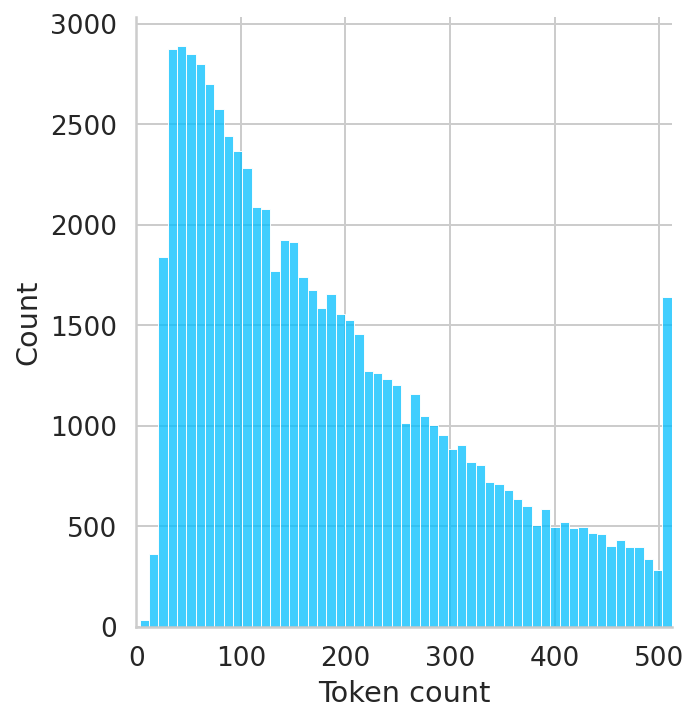

In [23]:
sns.displot(token_lens)
plt.xlim([0, 512]);
plt.xlabel('Token count');

In [24]:
(np.array(token_lens) == 512).sum()

1386

In [25]:
del data, df_humor, df_not_humor, tokens
gc.collect()

248

In [26]:
MAX_LEN = 512

In [27]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
      truncation=True
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [28]:
df_train, df_test = train_test_split(df, test_size=0.3, stratify=df.humor, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, stratify=df_test.humor, random_state=RANDOM_SEED)

In [29]:
df_train['humor'].value_counts()

0    25131
1    25130
Name: humor, dtype: int64

In [30]:
df_val['humor'].value_counts()

1    5385
0    5385
Name: humor, dtype: int64

In [31]:
df_test['humor'].value_counts()

1    5386
0    5385
Name: humor, dtype: int64

In [32]:
df_train.shape, df_val.shape, df_test.shape

((50261, 8), (10770, 8), (10771, 8))

In [33]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.review.to_numpy(),
    targets=df.humor.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=2
  )

In [34]:
BATCH_SIZE = 8

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [35]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [36]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([8, 512])
torch.Size([8, 512])
torch.Size([8])


In [37]:
class HumorClassifier(nn.Module):

  def __init__(self, n_classes):
    super(HumorClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME,  return_dict=False)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [38]:
model = HumorClassifier(len(class_names))
model = model.to(device)

In [39]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([8, 512])
torch.Size([8, 512])


In [40]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.5625, 0.4375],
        [0.3881, 0.6119],
        [0.5066, 0.4934],
        [0.3946, 0.6054],
        [0.2323, 0.7677],
        [0.2838, 0.7162],
        [0.4306, 0.5694],
        [0.3279, 0.6721]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [41]:
EPOCHS = 3

optimizer = AdamW(model.parameters(), lr=1e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [42]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [43]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [44]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/3
----------
Train loss 0.4312228565060578 accuracy 0.8142098247149877
Val   loss 0.4123321144323749 accuracy 0.8328690807799443

Epoch 2/3
----------
Train loss 0.36876323851978354 accuracy 0.8640297646286385
Val   loss 0.5088473588522764 accuracy 0.8350974930362116

Epoch 3/3
----------
Train loss 0.33168628797480265 accuracy 0.8959630727601918
Val   loss 0.5679389263455547 accuracy 0.8351903435468895

CPU times: user 50min 37s, sys: 36min 22s, total: 1h 26min 59s
Wall time: 1h 26min 49s


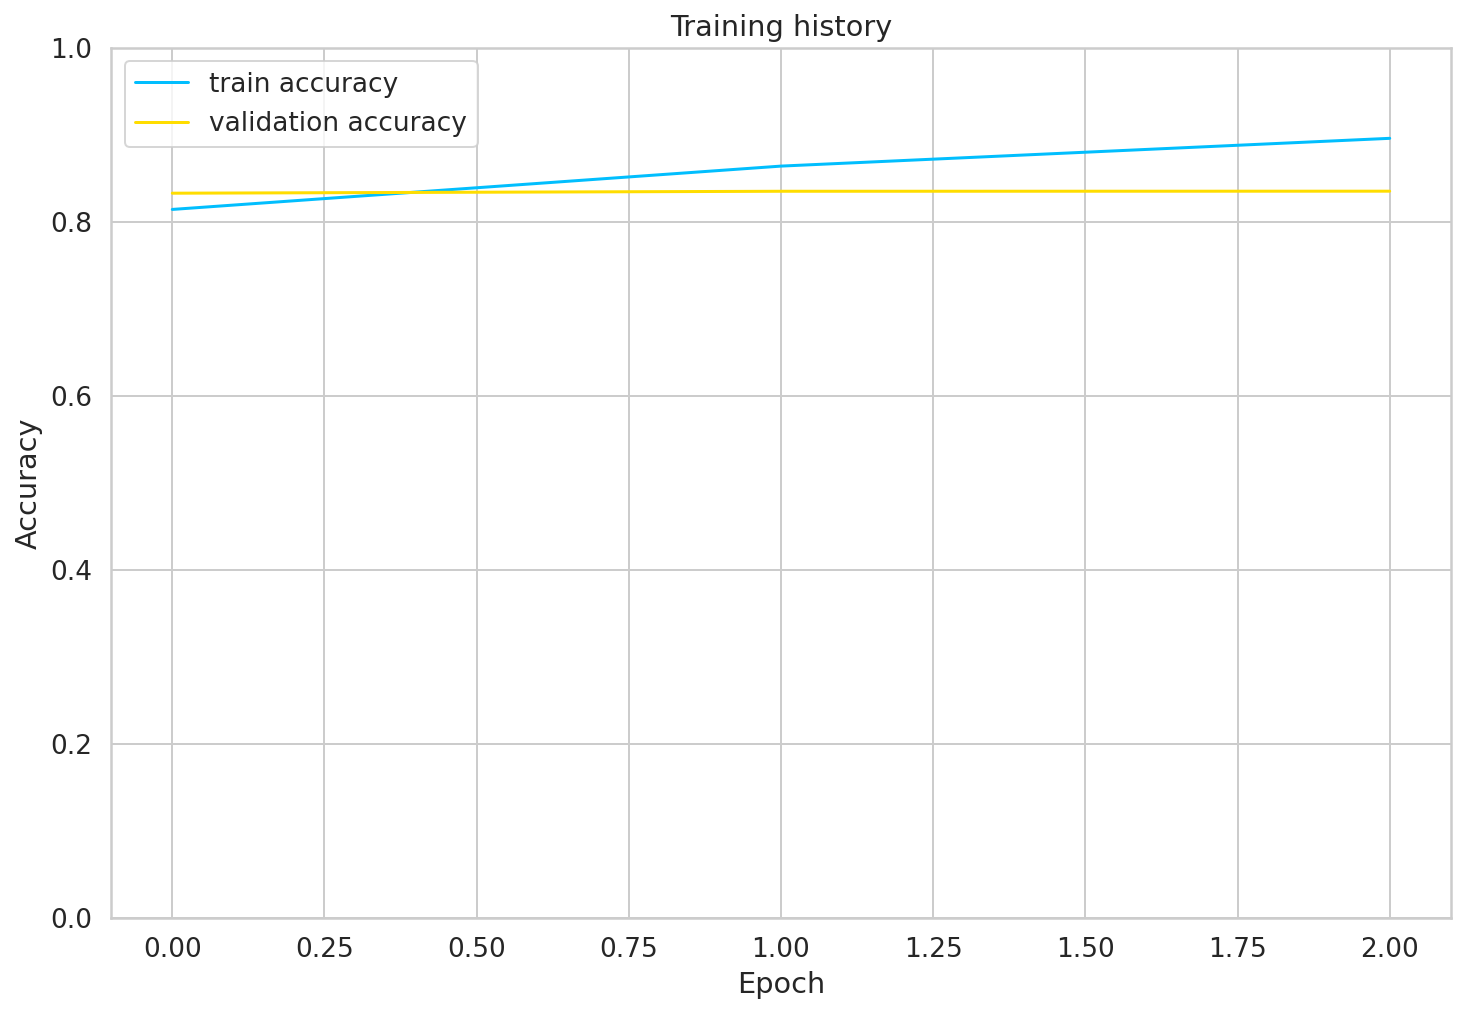

In [45]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [46]:
model = HumorClassifier(len(class_names))
model.load_state_dict(torch.load('best_model_state.bin'))
model = model.to(device)

In [47]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.8364125893603194

In [48]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [49]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [50]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

   not funny       0.81      0.88      0.84      5385
       funny       0.87      0.79      0.83      5386

    accuracy                           0.84     10771
   macro avg       0.84      0.84      0.84     10771
weighted avg       0.84      0.84      0.84     10771



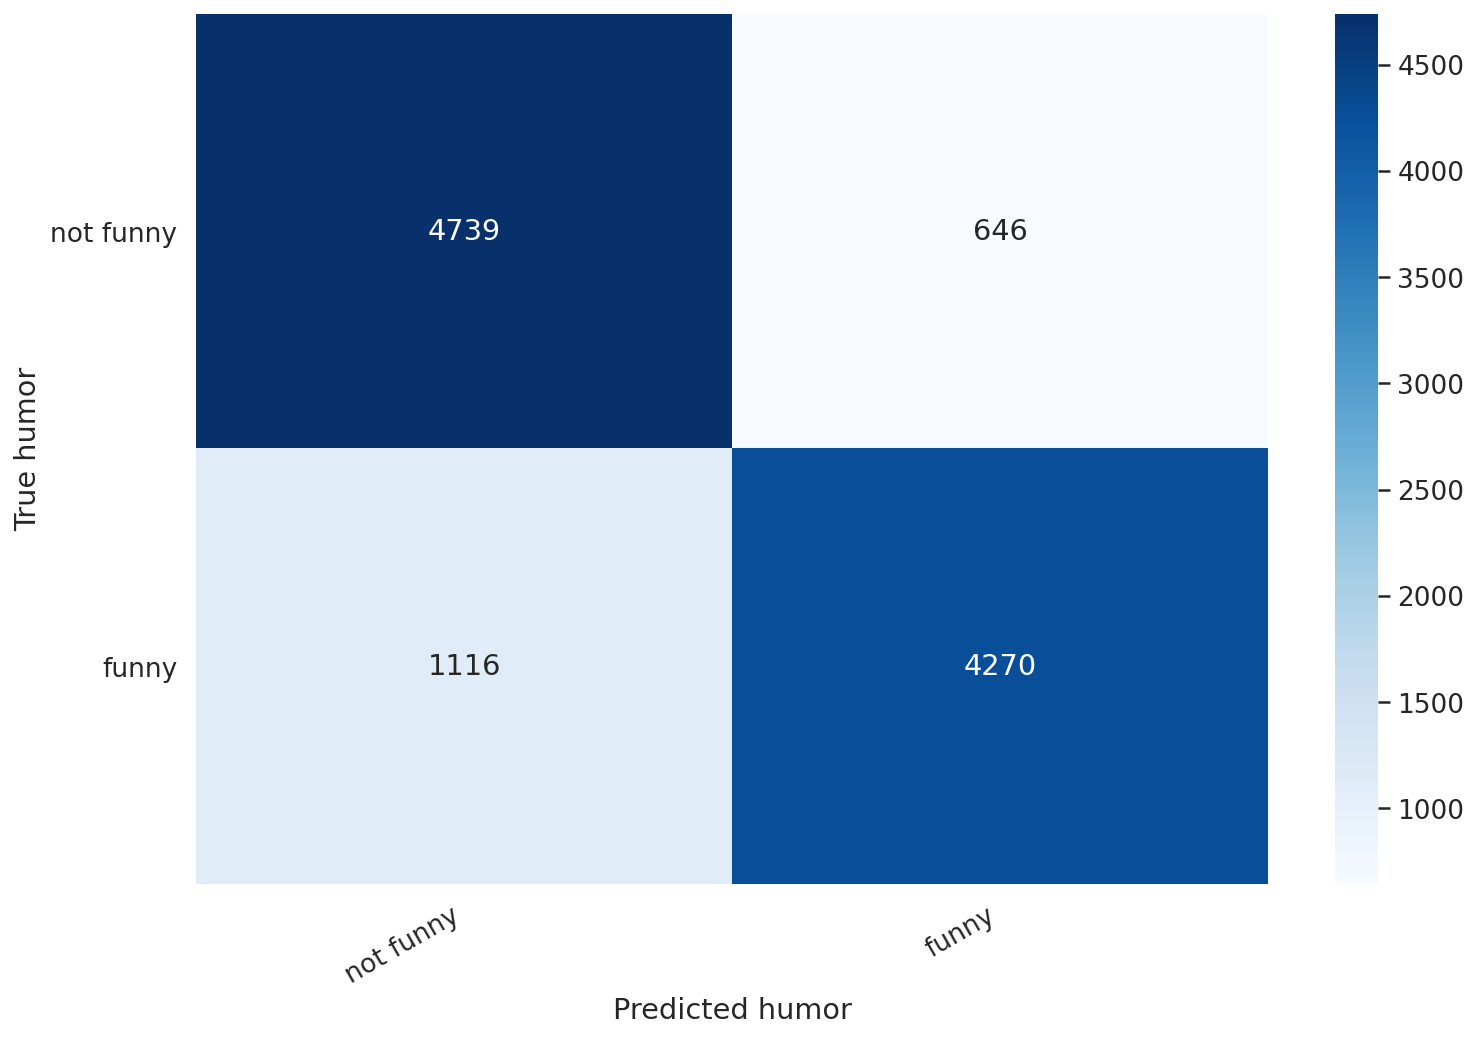

In [51]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True humor')
  plt.xlabel('Predicted humor');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [52]:
idx = 2

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [53]:
print("\n".join(wrap(review_text)))
print()
print(f'True humor: {class_names[true_sentiment]}')

Two words describe this place: "Freakin Sweet!" Although kind of off
the beaten path(basically it's a block east of 5th and Lamar) that's
actually where part of the appeal comes from. Anybody familiar with
the downtown area knows that yuppie bars(aside from being a total drag
and WAY over-priced) are also exceptionally pretentious. Not so with
The Tiniest Bar in Texas. This is one of those places where real
people can go after work and have cold beers and very well poured
drinks without having to break the bank or sit next to some stiff with
a nasal problem boo-hooing the fact the NASDAQ is down two-tenths of a
point. The staff are exceptional and those ladies are HOT! Also, they
offer a variety of drinks/beers as well as atmospheres in which to
enjoy them. You can stay inside and play some Wii on the plasma
screen, or take it outside and watch the people pass by on 5th(and
there are bars in both!). And even better still, it's close to some
great places to eat, so if you've had a few t

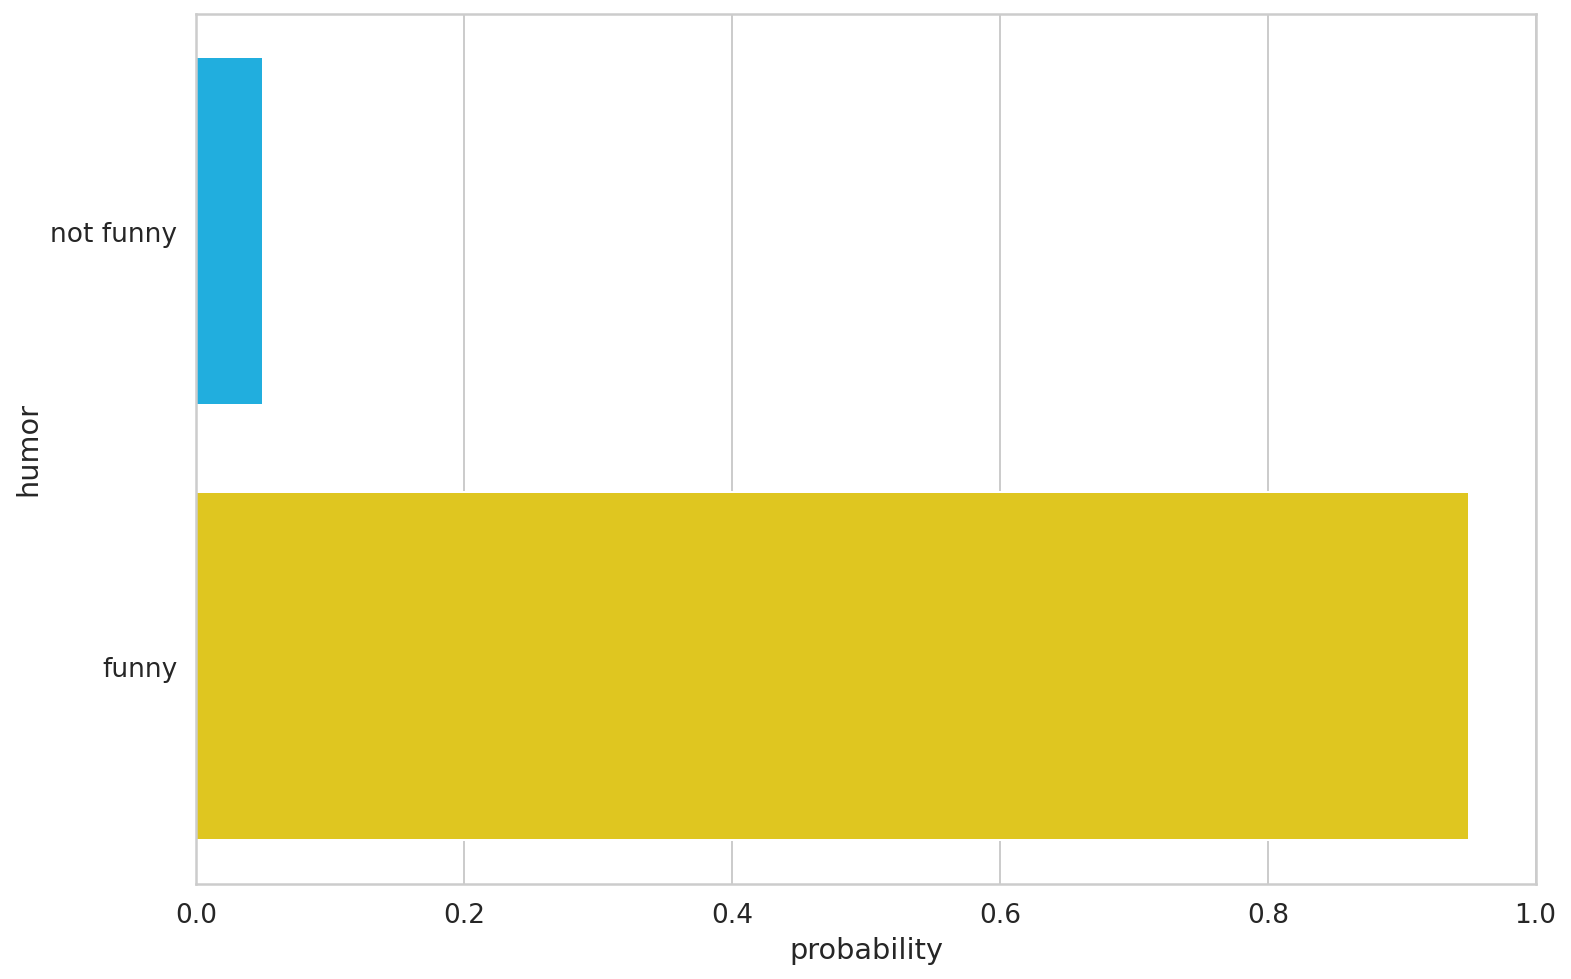

In [54]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('humor')
plt.xlabel('probability')
plt.xlim([0, 1]);